In [42]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_qxy(x, lambda_, pixel_size, pos_direct_x, D, PONI_x, delta):
    # Calculate the position of the direct beam on the rotated detector
    pos_direct_x = PONI_x - (D / pixel_size) * np.tan(np.radians(delta))
    
    # Calculate the angle theta for each pixel with horizontal coordinate x
    theta = np.arctan(pixel_size * (x - pos_direct_x) / D)/2.
    
    # Calculate q_xy
    qxy = (4 * np.pi / lambda_) * np.sin(theta)
    
    return qxy

def calculate_qz(y, lambda_, pixel_size, pos_direct_y, D, PONI_y, gamma, alpha_i):
    # Calculate the position of the direct beam on the rotated detector
    pos_direct_y = PONI_y + (D / pixel_size) * np.tan(np.radians(gamma))
    
    # Calculate the final angle alpha_f for each pixel with vertical coordinate y
    alpha_f = np.arctan((pixel_size * (pos_direct_y - y)) / D) - np.radians(alpha_i)
    
    # Calculate q_z
    qz = (2 * np.pi / lambda_) * (np.sin(alpha_f) + np.sin(np.radians(alpha_i)))
    
    return qz

# Function to load the data from a CSV file (one-line header, space-separated)
def load_data(file_path):
    # Load the file with numpy, assuming it's space-separated and has a single-line header
    data = np.loadtxt(file_path, delimiter=None, skiprows=1)
    
    # The first column represents pixel values and the second column represents intensity values
    x_values = data[:, 0]  # Column 0 as pixel values
    intensity_values = data[:, 1]  # Column 1 as intensity values
    
    return x_values, intensity_values

# Process data for q_xy or q_z
def process_file(file_path, lambda_, pixel_size, D, PONI_x, delta, PONI_y=None, gamma=None, alpha_i=None):
    # Load the data from the file
    pixel_values, intensity_values = load_data(file_path)
    
    if gamma is None:
        # Calculate q_xy for each pixel value
        qxy_values = np.array([calculate_qxy(x, lambda_, pixel_size, 0, D, PONI_x, delta) for x in pixel_values])
        # Combine the results
        processed_data = np.column_stack((pixel_values, qxy_values, intensity_values))
    else:
        # Calculate q_z for each pixel value
        qz_values = np.array([calculate_qz(y, lambda_, pixel_size, 0, D, PONI_y, gamma, alpha_i) for y in pixel_values])
        # Combine the results
        processed_data = np.column_stack((pixel_values, qz_values, intensity_values))
    
    return processed_data

# Example values (replace with your actual values)
lambda_ = 1.24e-10  # Wavelength in meters
pixel_size = 172e-6  # Pixel size in meters
D = 0.35  # Distance between detector and sample in meters
PONI_x = 563.5  # Example value for PONI_x
delta = -8.7  # In-plane angle in degrees

# Example values for q_z (replace with actual values)
PONI_y = 1015  # Example value for PONI_y
alpha_i = 0.12  # Incident angle in degrees

# Paths to files
# In-plane file
file_path_qxy = '5151-pixel-integration-horizontal.txt'

# First out-of-plane angle and file
gamma_1 = -0.75  # Out-of-plane angle in degrees
file_path_qz_1 = '5151-pixel-integration-vertical.txt'
# Second out-of-plane angle and file
gamma_2 = -1.4  # Out-of-plane angle in degrees
file_path_qz_2 = '5152-pixel-integration-vertical.txt'



# Process the files
processed_data_qxy = process_file(file_path_qxy, lambda_, pixel_size, D, PONI_x, delta)
processed_data_qz_1 = process_file(file_path_qz_1, lambda_, pixel_size, D, None, None, PONI_y, gamma_1, alpha_i)
processed_data_qz_2 = process_file(file_path_qz_2, lambda_, pixel_size, D, None, None, PONI_y, gamma_2, alpha_i)

# Convert q_xy to Å^-1 for q_xy
processed_data_qxy[:, 1] = processed_data_qxy[:, 1] * 1e-10

# Convert q_z to Å^-1 for q_z
processed_data_qz_1[:, 1] = processed_data_qz_1[:, 1] * 1e-10
processed_data_qz_2[:, 1] = processed_data_qz_2[:, 1] * 1e-10

# Save the results to new files
np.savetxt('processed_data_qxy.csv', processed_data_qxy, delimiter=';', header="Pixel;q_xy(A^-1);Intensity", comments='', fmt='%f')
np.savetxt('processed_data_qz_1.csv', processed_data_qz_1, delimiter=';', header="Pixel;q_z(A^-1);Intensity", comments='', fmt='%f')
np.savetxt('processed_data_qz_2.csv', processed_data_qz_2, delimiter=';', header="Pixel;q_z(A^-1);Intensity", comments='', fmt='%f')



(0.0, 30000.0)

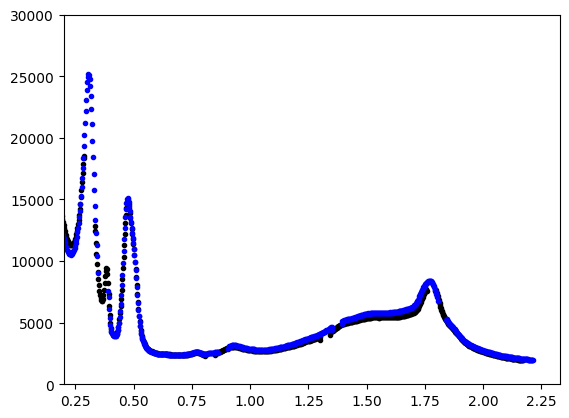

In [78]:
plt.plot(processed_data_qz_2[:, 1], processed_data_qz_2[:, 2], 'k.')
plt.plot(processed_data_qz_1[:, 1], processed_data_qz_1[:, 2], 'b.')
plt.xlim(0.2,)
plt.ylim(0,30000)
#plt.yscale('log')

(0.0, 2.1465121160603244)

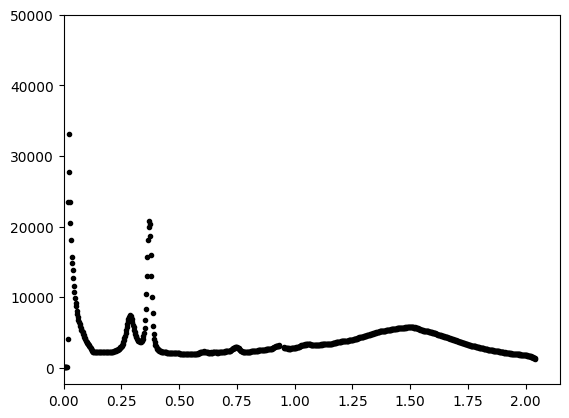

In [83]:
plt.plot(processed_data_qxy[:, 1]*-1, processed_data_qxy[:, 2], 'k.')
plt.xlim(0,)

(0.0, 30000.0)

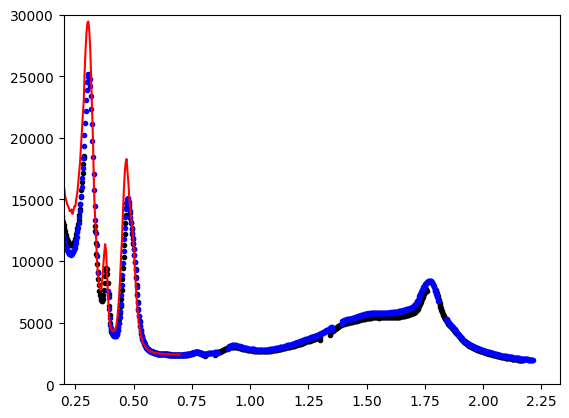

In [86]:
# Load the file with numpy, assuming it's space-separated and has a single-line header
data = np.loadtxt('5151-5152-direct-integration-qz.txt', delimiter=None, skiprows=1)

# The first column represents qxy values and the second column represents intensity values
qz_direct_values = data[:, 0]  # Column 0 as pixel values
intensity_direct_values = data[:, 1]  # Column 1 as intensity values


plt.plot(processed_data_qz_2[:, 1], processed_data_qz_2[:, 2], 'k.')
plt.plot(processed_data_qz_1[:, 1], processed_data_qz_1[:, 2], 'b.')
plt.plot(qz_direct_values,intensity_direct_values, 'r-')
plt.xlim(0.2,)
plt.ylim(0,30000)
#plt.yscale('log')

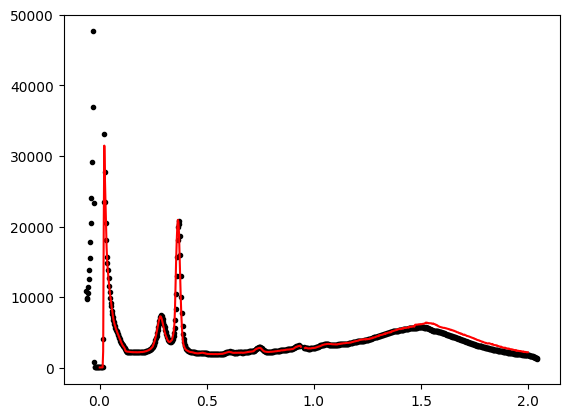

In [104]:
# Load the file with numpy, assuming it's space-separated and has a single-line header
data = np.loadtxt('5151-5152-direct-integration-qxy.txt', delimiter=None, skiprows=1)

# The first column represents qxy values and the second column represents intensity values
qxy_direct_values = data[:, 0]  # Column 0 as pixel values
intensity_direct_values = data[:, 1]  # Column 1 as intensity values

plt.plot(processed_data_qxy[:, 1]*-1, processed_data_qxy[:, 2], 'k.')
plt.plot(qxy_direct_values*-1,intensity_direct_values, 'r-')
#plt.xlim(0.2,0.4)
#plt.ylim(0,30000)
#plt.yscale('log')

#PREFER DIRECT INTEGRATION

(0.0, 30000.0)

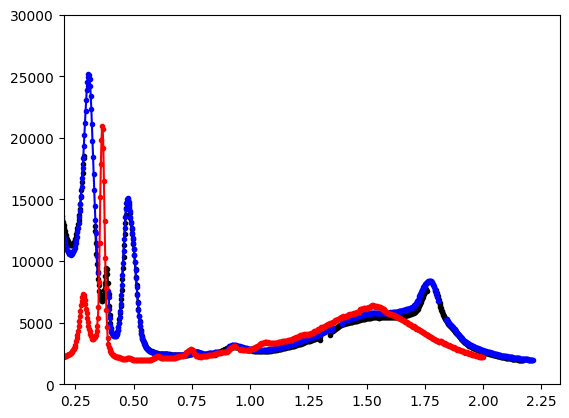

In [114]:
plt.plot(processed_data_qz_2[:, 1], processed_data_qz_2[:, 2], 'k.-')
plt.plot(processed_data_qz_1[:, 1], processed_data_qz_1[:, 2], 'b.-')
plt.plot(qxy_direct_values*-1,intensity_direct_values, 'r.-')
plt.xlim(0.2,)
#plt.xlim(0.4,0.5)
plt.ylim(0,30000)
#plt.yscale('log')